In [50]:
import pandas as pd
import ast

from data.fetch_data import *
from strategies.alphas import *
from utils.ga_utils import *
import warnings
from utils.optimizer import *
from utils.data_utils import * 

warnings.filterwarnings("ignore")

def normalize_alphas(column):
    column = column.values.reshape(-1, 1)

    # Create the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit and transform the data
    normalized_column = scaler.fit_transform(column)

    return normalized_column

def compute_labels(data, x_pct, n_days):
    labels = []
    for index, row in data.iterrows():
        row_index = data.index.get_loc(index)  # Get the integer index
        future_prices = data['Close'].iloc[row_index + 1:row_index + n_days + 1]
        price_change = (future_prices / row['Close']) - 1
        if any(price_change >= x_pct):
            labels.append(1)  # Price went up by x_pct or more within next n days
        else:
            labels.append(0)  # Price didn't go up by x_pct within next n days
    return labels

train_data = fetch_stock_data("BPCL.NS",'2021-08-01','2023-08-08')
test_data= yf.download("BPCL.NS", start = '2023-08-01',end='2024-02-11')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score
from sklearn.tree import DecisionTreeClassifier



data = train_data
data['alpha'] = normalize_alphas(alpha102(data,5,10))
y = compute_labels(data, 0.03, 5)
data=data.drop(["Close","Open","Volume",'High', 'Low', 'Adj Close'],axis =1 )

data_test = test_data
data_test['alpha'] =normalize_alphas(alpha102(data_test,5,10))
y_test = compute_labels(data_test,0.03,5)
data_test=data_test.drop(["Close","Open","Volume",'High', 'Low', 'Adj Close'],axis =1 )



# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

# Initialize the random forest classifier
rf_classifier = DecisionTreeClassifier(max_depth=6)

# Train the random forest classifier
rf_classifier.fit(data, y)

# Make predictions on the test set
y_pred = rf_classifier.predict(data_test)

# Evaluate the model
accuracy = precision_score(y_test, y_pred)
print("Precision:", accuracy)


Precision: 0.37662337662337664


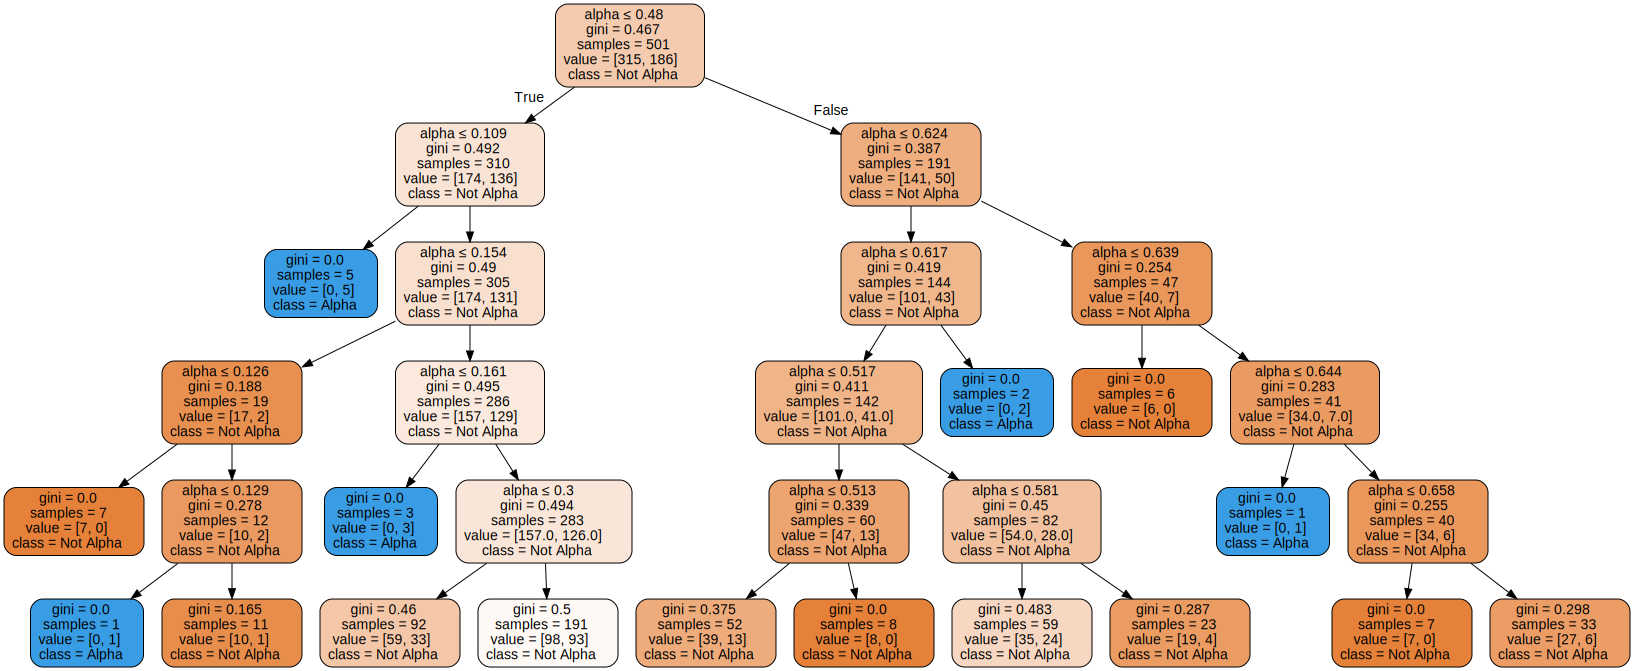

In [9]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Export the decision tree to a DOT file
export_graphviz(rf_classifier, out_file="tree.dot", 
                feature_names=data.columns,
                class_names=["Not Alpha", "Alpha"],  # Assuming binary classification
                filled=True, rounded=True,
                special_characters=True)

# Render the decision tree using Graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


In [61]:
data_test["act"] = y_test
data_test["res"] = y_pred

data_test[data_test.res == 1]

,alpha,act,res
Date,,,
2023-08-02,0.089569,0,1
2023-08-03,0.068004,0,1
2023-08-04,0.027988,0,1
2023-08-07,0.013057,0,1
2023-08-08,0.000000,0,1
...,...,...,...
2024-01-17,0.236417,0,1
2024-01-18,0.247030,1,1
2024-01-23,0.210537,1,1


In [66]:
a = len([i for i,j in zip(y_pred,y_test) if i==1 and j==1] )
b = len([i for i in y_pred if i == 1])

In [67]:
print(a,b)
a/b

21 38


0.5526315789473685

In [35]:
def evaluate_strategy(data, rf_model, stop_loss_percentage):
    data = data.copy()  # Make a copy of the data to avoid modifying the original DataFrame
    data['alpha'] = alpha14(data, 9)  # Assuming you still want to compute alpha

    position = 0  # 0 for no position, 1 for long position
    profit = 0
    total_trades = 0
    winning_trades = 0
    stricly_winning_trades = 0
    allocated_funds = 100000
    returns = []

    for i in range(1, len(data)):
        try:
            if position == 0:
                # Predict using the random forest model
                if rf_model.predict([data.iloc[i]['alpha']]) == 1:  # If model predicts 1, enter long position
                    position = 1
                    entry_price = data['Close'][i]
                    stop_loss_price = entry_price - (entry_price * 0.01 * stop_loss_percentage)
                    total_trades += 1
                    no_of_shares = allocated_funds // entry_price
            elif position == 1:
                # Exiting logic remains the same
                pass
            # Rest of the code remains unchanged

        except Exception as ex:
            print("Error occurred:", ex)
            break

    # Calculate and return metrics
    win_rate = winning_trades / total_trades if total_trades != 0 else 0
    metrics = {
        "Profit": profit,
        "Total Trades": total_trades,
        "Winning Trades": winning_trades,
        "Strictly Winning Trades": stricly_winning_trades,
        "Win Rate": win_rate,
        "Allocated Funds": allocated_funds,
        "Sharpe Ratio": calculate_sortino_ratio(pd.Series(returns))
    }
    return metrics


In [36]:
evaluate_strategy(test_data,rf_classifier,1)

Error occurred: Expected 2D array, got 1D array instead:
array=[nan].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


{'Profit': 0,
 'Total Trades': 0,
 'Winning Trades': 0,
 'Strictly Winning Trades': 0,
 'Win Rate': 0,
 'Allocated Funds': 100000,
 'Sharpe Ratio': nan}

In [ ]:
import importlib
tickers = []
alpha_function_names = ["alpha"+str(x) for x in range(102,103)]
alpha_functions = {}

for alpha_name in alpha_function_names:
    try:
        print(f"for {alpha_name}\n")
        module = importlib.import_module("strategies.alphas")
        alpha_function = getattr(module, alpha_name)
        alpha_functions[alpha_name] = alpha_function

        best_metrics, best_individual = run_ga_optimization(train_data, generate_individual, alpha_function, evaluate_strategy)

        results_dict[alpha_function.__name__] = {
        # "alpha_name": alpha_function.__name__,
        "best_metrics": best_metrics,
        "best_individual": best_individual,
    }
        
    except Exception as ex:
        print(f"Failed {alpha_name}",ex)